* Import all the relevant libraries

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, box
import numpy as np
import matplotlib.pyplot as plt
import joblib

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
def createDataSets(data):
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))    
    gdf.set_crs('epsg:4326', inplace=True)

    gdf['Latitude'] = pd.to_numeric(gdf['Latitude'], errors='coerce')
    gdf['Longitude'] = pd.to_numeric(gdf['Longitude'], errors='coerce')

    gdf['mean_lat_long'] = gdf[['Latitude', 'Longitude']].mean(axis=1)
    
    gdf = gdf.dropna(subset=['Longitude', 'Latitude'])

    gdf = gdf.query('Latitude <= 10 & Longitude <= 10')

    min_x, min_y, max_x, max_y = gdf.total_bounds

    length = 0.25
    wide = 0.25

    cols = list(np.arange(min_x, max_x + wide, wide))
    rows = list(np.arange(min_y, max_y + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

    grid = gpd.GeoDataFrame({'geometry':polygons}).set_crs('epsg:4326', inplace=True)
    
    grid['ID'] = range(1, grid.shape[0]+1)
    grid = grid[['ID'] + [col for col in grid.columns if col != 'ID']]

    gdf = gpd.overlay(grid, gdf, how='intersection', keep_geom_type=False)
    gdf = gdf.rename(columns={'ID': 'Bin_ID'})
    
    merged = gpd.sjoin(grid, gdf, how="right", predicate='intersects')
    aggregated_values = merged.groupby('ID')['mean_lat_long'].mean().reset_index(name='aggregated_values')
    merged = merged.groupby('ID').size().reset_index(name='count')

    grid = grid.merge(merged, on='ID')
    grid = grid.merge(aggregated_values, on='ID')

    return gdf, grid

In [4]:
def plotData(gdf, grid):
    gdf.plot(ax=grid.plot(linewidth=1, edgecolor='black',alpha=0.5), marker='o', markersize=5, color='red')
    plt.title("My Data and Grid")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

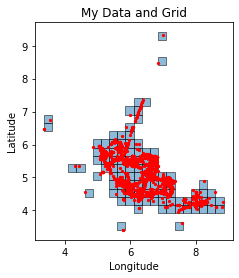

In [5]:
data = gpd.read_file('Book1.csv')
data['Date'] = pd.to_datetime(data['Date'])

data.replace('',np.nan,inplace=True)
data = data.dropna(subset=['Latitude', 'Longitude'])

gdf, grid = createDataSets(data)

plotData(gdf, grid)

## ML Part

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.wrappers.scikit_learn import KerasRegressor

In [7]:
test = gdf.copy()

test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day
test['dayofweek'] = test['Date'].dt.dayofweek

X = test[['month', 'day', 'dayofweek']]
y = test[['Latitude', 'Longitude']]

X_augmented = X.copy()
y_augmented = y.copy()

X_augmented['month'] = X_augmented['month'] + np.random.normal(0, 0.12, len(X_augmented))
X_augmented['day'] = X_augmented['day'] + np.random.normal(0, 0.12, len(X_augmented))
X_augmented['dayofweek'] = X_augmented['dayofweek'] + np.random.normal(0, 0.12, len(X_augmented))

y_augmented['Latitude'] = y_augmented['Latitude'] + np.random.normal(0, 0.12, len(y_augmented))
y_augmented['Longitude'] = y_augmented['Longitude'] + np.random.normal(0, 0.12, len(y_augmented))

X_augmented = pd.concat([X, X_augmented], axis=0)
y_augmented = pd.concat([y, y_augmented], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.05, random_state=12)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
def create_model(lstm1_neurons=53, lstm2_neurons=95, lstm3_neurons=95, optimizer='rmsprop'):
    model = Sequential()
    model.add(LSTM(lstm1_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm2_neurons, return_sequences=True))
    model.add(LSTM(lstm3_neurons))
    model.add(Dense(2))
    model.compile(loss='mse', optimizer=optimizer)
    return model

#### Load the model(s)

In [12]:
random_search = joblib.load('models/model.pkl')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-01-23 00:33:12         3458
metadata.json                                  2023-01-23 00:33:12           64
variables.h5                                   2023-01-23 00:33:12      1161560
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


In [13]:
y_pred = random_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("R-Squared: ", r2)

16/16 - 4s - 4s/epoch - 245ms/step
Mean Squared Error:  0.01032531289125976
Mean Absolute Error:  0.08152988114612719
Root Mean Squared Error:  0.10161354679007992
R-Squared:  -0.06251793140349893


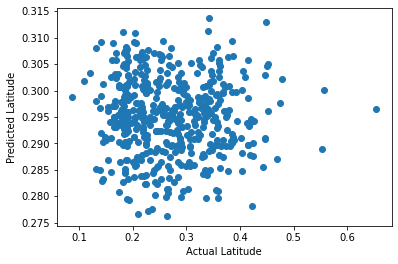

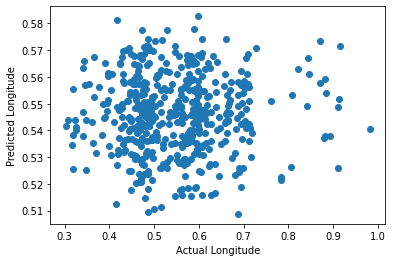

In [14]:
predicted_latitude = y_pred[:,0]
actual_latitude = y_test[:,0]
predicted_longitude = y_pred[:,1]
actual_longitude = y_test[:,1]

#Create a scatter plot for Latitude
plt.scatter(actual_latitude, predicted_latitude)
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.show()

#Create a scatter plot for Longitude
plt.scatter(actual_longitude, predicted_longitude)
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.show()


## Predicting new values

In [15]:
def predictNewPoint(new_date, data):
    new_date = pd.to_datetime(new_date)

    new_month = new_date.month
    new_day = new_date.day
    new_dayofweek = new_date.dayofweek

    new_date_df = {'month': new_month, 'day': new_day, 'dayofweek': new_dayofweek}
    new_date_df = pd.DataFrame(new_date_df, index=[0])

    new_date_df = scaler_x.transform(new_date_df)
    new_date_df = new_date_df.reshape((new_date_df.shape[0], 1, new_date_df.shape[1]))

    new_prediction = random_search.predict(new_date_df)
    new_prediction = new_prediction.reshape(1,-1)
    new_prediction = scaler_y.inverse_transform(new_prediction)

    new_latitude = new_prediction[0][0]
    new_longitude = new_prediction[0][1]

    new_entry = {'Date': new_date, 'Latitude': new_latitude, 'Longitude': new_longitude, 'geometry': gpd.points_from_xy([new_longitude], [new_latitude])}

    new_entry = gpd.GeoDataFrame(new_entry, index=[0])

    max_index = data.index.max()
    new_entry.index = [max_index + 1]

    return new_entry

In [21]:
new_entry = predictNewPoint('15-08-26', data)

data = pd.concat([data, new_entry], axis=0)

new_gdf, new_grid = createDataSets(data)

1/1 - 0s - 82ms/epoch - 82ms/step
